# Run Ensemble Mean upon Anemoi Models
Connecting cascade and anemoi allows for distributed and managed execution of models, and generation of products.

In [1]:
import anemoicascade as ac

In [2]:
import os

# Setup Environment
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True'
os.environ['LD_LIBRARY_PATH'] = f"INSERT_LD_LIBRARY_PATH_HERE:{os.environ['LD_LIBRARY_PATH']}"

## Additional cascade actions
`pproc-cascade` provides an action api for advanced production generation, but depends on pproc

In [38]:
from cascade import Cascade
import earthkit.data as ekd

PPCASCADE_IMPORTED = True
try:
    from ppcascade import fluent as ppfluent
except (RuntimeError, ImportError) as e:
    print('pproc cascade could not be imported', e)
    PPCASCADE_IMPORTED = False

pproc cascade could not be imported FDB5 library not found


In [4]:
CKPT = "/lus/h2resw01/hpcperm/ecm0672/pub/anemoi-ckpt/inference-aifs-0.2.1-anemoi.ckpt"

With the environment ready, and the ckpt established, we can begin to call a prediction

In [5]:
ac.fluent.from_model?

Signature:
ac.fluent.from_model(
    ckpt,
    start_date: str,
    lead_time: int,
    *,
    num_ensembles: int = 1,
    input_type: Literal['mars', 'file'] = 'mars',
    action: type[cascade.fluent.Action] = <class 'cascade.fluent.Action'>,
    devices: list[str] | str | None = None,
    input_kwargs: dict[str, typing.Any] = None,
    **kwargs,
) -> cascade.fluent.Action
Docstring:
Create a Cascade Graph from a model prediction

Will be automatically expanded to the correct dimensions
of param, step and ensemble.

Parameters
----------
ckpt :
    Location of ckpt to load
start_date : str
    Start date of prediction, used to get initial conditions
lead_time : int
    Hours to predict out to
num_ensembles : int, optional
    Number of ensembles to create, by default 1
input_type : INPUT_TYPES, optional
    Source of input data, by default "mars"
action : type[fluent.Action], optional
    Cascade action to use, by default fluent.Action
devices : list[str] | str | None, optional
    De

All that is needed to run a prediction is the:
- checkpoint
- Start time
- Lead time

From there, the number of ensembles can be set, which is automatically added as a dimension

Note:
    Some issues do occur with running out of memory at higher ensemble numbers

In [67]:
model_action = ac.fluent.from_model(CKPT, '2022-01-01T00:00', lead_time = 48, num_ensembles=4)
model_action

Now we can check the coordinates of the graph.

In [68]:
model_action.nodes.coords

Coordinates:
  * param            (param) object 704B 'sp' 'msl' '10u' ... 'z_925' 'z_1000'
  * step             (step) int64 64B 6 12 18 24 30 36 42 48
  * ensemble_member  (ensemble_member) int64 32B 0 1 2 3

In [69]:
if PPCASCADE_IMPORTED:
    from ppcascade.utils.window import Range
    
    interpolation = {
        "grid": "O320"
    }
    
    windows = [
                Range("0-24", [6, 12, 18, 24]), 
                Range("12-24", [12, 18, 24]), 
            ]


In [70]:
PRODUCT_CATALOG = {
    'ensemble_window_mean': lambda x: x.switch(ppfluent.Action).window_operation("mean", windows,dim="step", batch_size=2).ensemble_operation("mean", dim="ensemble_member"),
    'ensemble_mean': lambda x: x.select({'step':24}).mean(dim="ensemble_member"),
}

In [71]:
graph = PRODUCT_CATALOG['ensemble_mean'](model_action)

With the ensemble mean for a bunch of the params chosen, we can visualise the graph

In [72]:
cascade_sel = Cascade.from_actions([graph])
cascade_sel.visualise("EnsembleMean.html", cdn_resources='in_line', preset='none')

EnsembleMean.html


Now the fun part, execution...

In [73]:
%%time

from cascade.executors.dask import DaskLocalExecutor 

cascade_sel.executor = DaskLocalExecutor(memory_limit="24GB", n_workers=1, threads_per_worker=1)
results = cascade_sel.execute()

{'address': 'tcp://127.0.0.1:40645',
 'id': 'Scheduler-e2d1adab-d9a6-43cb-b46f-5f2130541b2a',
 'services': {'dashboard': 8787},
 'started': 1726842731.4561918,
 'type': 'Scheduler',
 'workers': {'tcp://127.0.0.1:35019': {'host': '127.0.0.1',
                                       'id': 0,
                                       'local_directory': '/dev/shm/_tmpdir_.ecm1947.31516152/dask-scratch-space/worker-fv4jf_lk',
                                       'memory_limit': 24000000000,
                                       'name': 0,
                                       'nanny': 'tcp://127.0.0.1:35443',
                                       'nthreads': 1,
                                       'resources': {},
                                       'services': {'dashboard': 37483},
                                       'status': 'init',
                                       'type': 'Worker'}}}


100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


MEAN: wall time: 0.0073777 s (7.3777 milliseconds), CPU time: 0.003296 s (3.296 milliseconds), memory: 8273829888 bytes (7.7056 GiB)
MEAN: wall time: 0.00651789 s (6.51789 milliseconds), CPU time: 0.002987 s (2.987 milliseconds), memory: 8273829888 bytes (7.7056 GiB)
MEAN: wall time: 0.00657075 s (6.57075 milliseconds), CPU time: 0.002352 s (2.352 milliseconds), memory: 8273829888 bytes (7.7056 GiB)
MEAN: wall time: 0.00650969 s (6.50969 milliseconds), CPU time: 0.001743 s (1.743 millisecond), memory: 8273829888 bytes (7.7056 GiB)
MEAN: wall time: 0.00653676 s (6.53676 milliseconds), CPU time: 0.002192 s (2.192 milliseconds), memory: 8273829888 bytes (7.7056 GiB)
MEAN: wall time: 0.00657973 s (6.57973 milliseconds), CPU time: 0.004249 s (4.249 milliseconds), memory: 8273829888 bytes (7.7056 GiB)
MEAN: wall time: 0.00648336 s (6.48336 milliseconds), CPU time: 0.002723 s (2.723 milliseconds), memory: 8273829888 bytes (7.7056 GiB)
MEAN: wall time: 0.00667178 s (6.67178 milliseconds), CPU 

In [74]:
combined_data = ekd.from_source('multi', list(results.values()))

In [75]:
combined_data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,q,isobaricInhPa,925,20220101,0,24,fc,0,reduced_gg
1,ecmf,z,isobaricInhPa,850,20220101,0,24,fc,0,reduced_gg
2,ecmf,t,isobaricInhPa,925,20220101,0,24,fc,0,reduced_gg
3,ecmf,skt,surface,0,20220101,0,24,fc,0,reduced_gg
4,ecmf,z,isobaricInhPa,925,20220101,0,24,fc,0,reduced_gg
...,...,...,...,...,...,...,...,...,...,...
83,ecmf,z,isobaricInhPa,600,20220101,0,24,fc,0,reduced_gg
84,ecmf,w,isobaricInhPa,100,20220101,0,24,fc,0,reduced_gg
85,ecmf,q,isobaricInhPa,700,20220101,0,24,fc,0,reduced_gg
86,ecmf,q,isobaricInhPa,200,20220101,0,24,fc,0,reduced_gg


## Plotting

In [77]:
from earthkit.regrid import interpolate
import earthkit.plots as ekp
import earthkit.plots.quickmap as qmap

In [89]:
VAR_OF_INTEREST = '2t'

In [90]:
# the target grid is a global 5x5 degree regular latitude grid
out_grid = {"grid": [0.25,0.25]}
r = interpolate(combined_data.sel(param = VAR_OF_INTEREST), out_grid=out_grid, method="linear")

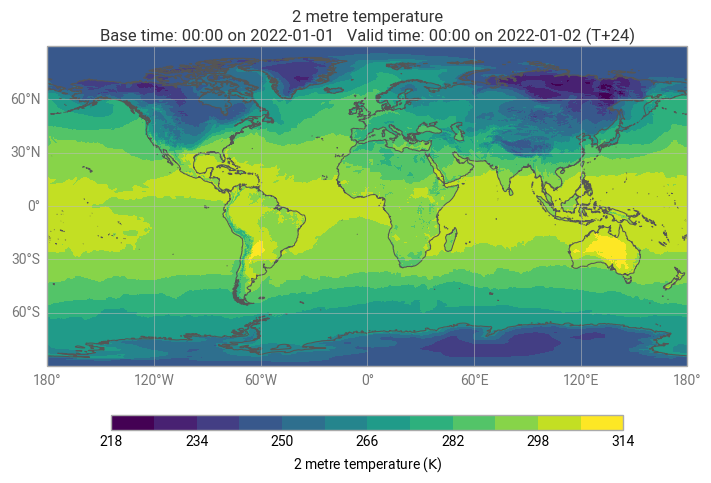

In [91]:
qmap.plot(r, colors = 'viridis')